<a href="https://colab.research.google.com/github/YuxingW/deep_learning/blob/main/hw4/part_1_mnist_classifier_with_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment
The assignment is to implement MNIST classifier fully with all the things learnt in last class with many features in numpy in a colab.

###Detail requirements

(a) The code should do mini batch gradient descent along with appropriate learning rate and pick appropriate batch size for minibatch.
<br />
(b) The code should do dropout - try various dropout rates and pick the one which works well.
<br />
(c) The code should do basic image augmentations to supplement the training data (not testing data) using keras libraries.
<br />
(d) The code should use  3 or more layers for training (not 2 as in example ) - you have to tune and pick number of neurons in your layer and number of layers
<br />
(e) The code will continue to use relu activation layer in right places like python code
<br />
(f) The code should normalize the input as discussed in the class before training (scaling the input)
<br />
(g) The code should use appropriate learning rate (try out few to find out which one works) - you can use adaptive learning rates like different learning rates per epoch or per mini batch.
<br />
(h) The code should provide appropriate metrics, visualization,  testing and training accuracy etc.,. and plot the results and confusion matrix  (this is important)
<br />
(i) The code should display top common errors like in below link.

# Data preprocessing

##Load and preprocessing mnist image dataset

In [1]:
import sys, numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

##Do image augmentations on the training data
Use ImageDataGenerator to generate augmentation data.

In [2]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.05, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        rescale = 0) # no rescaling is applied

train_augment = datagen.flow(x_train.reshape(-1,28,28, 1), y = y_train)

Covert the type/shape of the augmentation data to the same type/shape of x_train y_train

In [3]:
batch_index = 0
x_list, y_list = [], []
while batch_index <= train_augment.batch_index:
    data = train_augment.next()
    x_list.append(data[0])
    y_list.append(data[1])
    batch_index = batch_index + 1

x_augment = np.asarray(x_list).reshape(-1,28, 28)
y_augment = np.asarray(y_list).reshape(-1, )

##Normalize data and covert labels to one hot labels
Reshape image to 28*28, use augmentation data only for training, not for validation.

In [4]:
def convert_labels(labels):
  one_hot_labels = np.zeros((len(labels),10))
  for i,l in enumerate(labels):
      one_hot_labels[i][l] = 1
  return one_hot_labels

images, labels = (x_augment[0:60000].reshape(60000,28*28) / 255, y_augment[0:60000])
labels = convert_labels(labels)
x, y_true = images, labels

test_images, test_labels = x_test.reshape(len(x_test),28*28) / 255, y_test
test_labels = convert_labels(test_labels)
x_test, y_test = test_images, test_labels

print(f'images: {images.shape}, labels: {labels.shape}, test_images: {test_images.shape}, test_labels: {test_labels.shape}')

images: (60000, 784), labels: (60000, 10), test_images: (10000, 784), test_labels: (10000, 10)


#Model construction

##Construct neural network model with dropout rate
The model is constructed with linear->relu->relu->linear, drop out rate can be set on relu layers. <br />
Use MSE as loss function.

In [5]:
class Linear:
  def __init__(self, input_dim: int, hidden_dim: int = 1):
    self.weights = np.random.randn(input_dim, hidden_dim) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(hidden_dim)

  def __call__(self, _input):
    self.x = _input
    output = _input @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

class Relu:
  def __call__(self, input_, dropout_rate=0):
    if dropout_rate > 0:
      dropout_mask = np.random.binomial(1, 1 - dropout_rate, size=input_.shape)
      input_ *= dropout_mask * 2
    self.input_ = input_
    self.output = np.clip(self.input_, 0, None)
    return self.output

  def backward(self, output_gradient):
    # import pdb; pdb.set_trace()
    self.input_gradient = (self.input_ > 0) * output_gradient
    return self.input_gradient

class Model:
  def __init__(self, input_dim, hidden_dim, ouput_dim):
    self.linear1 = Linear(input_dim, hidden_dim)
    self.relu1 = Relu()
    self.relu2 = Relu()
    self.linear2 = Linear(hidden_dim, ouput_dim)

  def __call__(self, x):
    linear1 = self.linear1(x)
    # Do the drop out on the first relu layer
    relu1 = self.relu1(linear1, dropout_rate=0)
    relu2 = self.relu2(relu1, dropout_rate=0.01)
    linear2 = self.linear2(relu2)
    return linear2

  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu2_gradient = self.relu2.backward(linear2_gradient)
    relu1_gradient = self.relu1.backward(relu2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)
    # import pdb; pdb.set_trace()
    return linear1_gradient

  def update(self, learning_rate):
    self.linear2.update(learning_rate)
    self.linear1.update(learning_rate)

class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    #print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient

## Tune drop out rate
I have tried drop rate 0.1 0.05 0.01 on both relu layers, it appears 0.01 on the first relu layer performs the best.

# Model training (96% test accuracy)

##Initialize the model
The model is with 784-d input and 10-d output, 200 neurons for 2 hidden layers

In [6]:
loss = MSE()
nonlinear = Model(784, 200, 10)

## Define mini batch fit fuction

Do mini batch gradient descent along with the dynamic learning rate, learning rate starts from 0.01 and decays continuously while epoch is increasing

In [7]:
import math

def lr_decay(epoch):
  return 0.01 * math.pow(0.666, epoch)

In [8]:
from typing import Callable

def fit_by_batch(x: np.ndarray, y: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, model: Callable, loss: Callable, num_epochs: int, batch_size: int):
  for epoch in range(num_epochs):
    correct_cnt = 0
    lr = lr_decay(epoch/100)
    for i in range(int(len(x) / batch_size)):
      batch_start, batch_end = ((i * batch_size), ((i+1)*batch_size))
      x_batch = x[batch_start: batch_end]
      y_batch = y[batch_start: batch_end]
      # forward propagation
      y_pred_batch = model(x_batch)
      loss_value = loss(y_pred_batch, y_batch)
      # backward propagation
      gradient_from_loss = loss.backward()
      model.backward(gradient_from_loss)
      # update parameters
      model.update(lr)
      for k in range(batch_size):
        correct_cnt += int(np.argmax(y_pred_batch[k:k+1]) == np.argmax(y_batch[k:k+1]))

    if epoch % 100 == 0:
      test_correct_cnt = 0
      y_pred_test = model(x_test)
      for k in range(len(y_test)):
        test_correct_cnt += int(np.argmax(y_pred_test[k:k+1]) == np.argmax(y_test[k:k+1]))
      print(f'Epoch {epoch}, lr {lr}, loss {loss_value}, correct_rate {correct_cnt/float(len(y))}, test_correct_rate {test_correct_cnt/float(len(y_test))}')


##Train the model with tuning mini batch and learning rate
Tuning learning rate and batch size results
I have used dynamic learning rate, learning rate starts from 0.01 and decays continuously while epoch is increasing, which gets a better test accuracy than a fixed learning rate. <br />
Also, I have tried batch size 32 64 100 200, in which 64 performs best in terms of the test accuracy.

In [9]:
fit_by_batch(x, y_true, x_test, y_test, model=nonlinear, loss=loss, num_epochs=1500, batch_size=64)

Epoch 0, lr 0.01, loss 0.05794429271504657, correct_rate 0.5729833333333333, test_correct_rate 0.7825
Epoch 100, lr 0.00666, loss 0.015616181120113773, correct_rate 0.95405, test_correct_rate 0.9587
Epoch 200, lr 0.004435560000000001, loss 0.0123810780046356, correct_rate 0.9627333333333333, test_correct_rate 0.962
Epoch 300, lr 0.0029540829600000007, loss 0.01262258856314578, correct_rate 0.9662333333333334, test_correct_rate 0.9641
Epoch 400, lr 0.0019674192513600007, loss 0.010680089311422508, correct_rate 0.9681333333333333, test_correct_rate 0.9647
Epoch 500, lr 0.0013103012214057605, loss 0.011464747970145614, correct_rate 0.9692166666666666, test_correct_rate 0.9653
Epoch 600, lr 0.0008726606134562365, loss 0.01002503246841475, correct_rate 0.9694333333333334, test_correct_rate 0.9653
Epoch 700, lr 0.0005811919685618535, loss 0.010221869623984133, correct_rate 0.9701833333333333, test_correct_rate 0.9654
Epoch 800, lr 0.0003870738510621945, loss 0.010050447350322391, correct_rat

# Model evaluation

## Plot confusion matrix

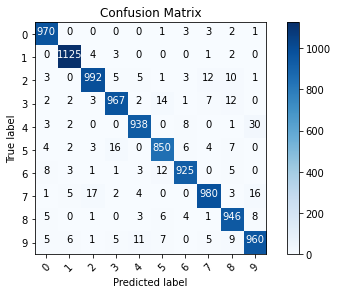

In [10]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cfs_matrix, labels,
                          normalize=False,
                          plt_title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cfs_matrix, interpolation='nearest', cmap=cmap)
    plt.title(plt_title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    if normalize:
        cfs_matrix = cfs_matrix.astype('float') / cfs_matrix.sum(axis=1)[:, np.newaxis]

    thresh = cfs_matrix.max() / 2.
    for i, j in itertools.product(range(cfs_matrix.shape[0]), range(cfs_matrix.shape[1])):
        plt.text(j, i, cfs_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cfs_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = nonlinear(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, labels= range(10)) 

##Display top common errors

In [11]:
# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)


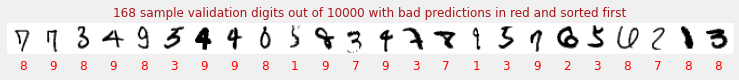

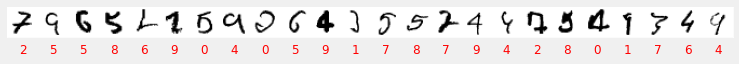

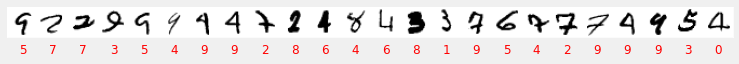

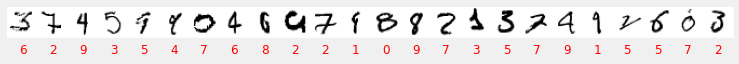

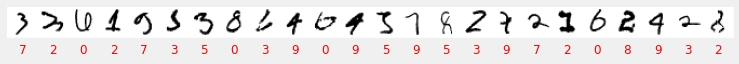

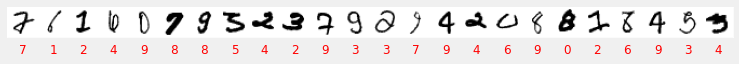

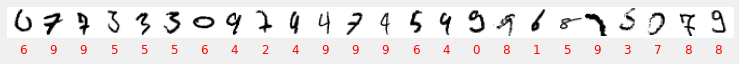

In [12]:
# number of digits in one row
N = 24
# recognize validation digits
display_top_unrecognized(x_test, Y_pred_classes, Y_true, N, 7)

#Referrences
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6 <br />
https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist#0
